---
title: Animated scatter plot with size legend with matplotlib
date: '2025-04-17'
categories:
  - animation
  - matplotlib
---

I have been looking at generating animated plots using Matplotlib, with the [official documentation](https://matplotlib.org/stable/users/explain/animations/animations.html) providing an excellent example for basic animations.

However, I couldn't find any good examples of generating animations with legends for size of the marker in a scatter plot. I had been looking to animate the time and magnitude of the [25th April 2015 earthquake of Nepal](https://en.wikipedia.org/wiki/April_2015_Nepal_earthquake) along with its foreshocks and aftershocks.

In this post, I will explain how I managed to achieve that (*with help from some excellent references online, of course*).

## Getting the earthquake data

The first step is of course to the get the data about the earthquakes. This is easily available using the [USGS Catalog](https://earthquake.usgs.gov/earthquakes/search/). I used `geopandas` to directly read a `GeoDataFrame` from the catalog's API, but I won't go into a lot of details here; the code below should be self explanatory.

One important thing to note is that the catalog API doesn't support filtering by country. It only supports filtering by latitutde and longitude bounds (*west, south, east, north*). After this, I used the `within` method of `geopandas` to limit the results to earthquakes that occured only in Nepal. The `within` method requires a Polygon object. For this, I directly downloaded a *GeoJSON* file of the administrative boundaries from the [*geoBoundaries*](https://github.com/wmgeolab/geoBoundaries/tree/b7dd6a55701c76a330500ad9d9240f2b9997c6a8?tab=readme-ov-file) project on GitHub.


In [1]:
import urllib.parse

import geopandas as gpd
import pandas as pd

# these are the rough bounds of the earthquake and its aftershocks
minlatitude, maxlatitude = 27, 29
minlongitude, maxlongitude = 84, 87

# limiting the search to April and May 2015, and only those >= 5 magnitude
CATALOG_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson"
params = {
    "starttime": "2015-04-01",
    "endtime": "2015-05-31",
    "maxlatitude": maxlatitude,
    "minlatitude": minlatitude,
    "maxlongitude": maxlongitude,
    "minlongitude": minlongitude,
    "minmagnitude": 5,
    "eventtype": "earthquake",
    "orderby": "time",
}
columns = ["mag", "time", "geometry"]

url = f"{CATALOG_URL}?{urllib.parse.urlencode(params)}"
quakes = gpd.read_file(url, columns=columns)

# get the national boundary of Nepal
boundary_url = "https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/refs/heads/main/releaseData/gbOpen/NPL/ADM0/geoBoundaries-NPL-ADM0.geojson"
nepal = gpd.read_file(boundary_url)

# ensure both dataframes are in the same CRS
quakes = quakes.to_crs(nepal.crs)

# filter earthquakes to those within Nepal's boundaries
quakes = quakes[quakes.within(nepal.iloc[0]['geometry'])]

# sort from earliest to latest
# localize the datetime to Nepal's datetime
quakes = quakes.sort_values("time", ascending=True, ignore_index=True)
quakes["time"] = pd.to_datetime(quakes["time"], unit="ms").dt.tz_localize(
    tz="Asia/Kathmandu",
)

# for working with matplotlib, add separate latitude/longitude columns
quakes = quakes.join(
    quakes.get_coordinates().rename(columns=dict(y="latitude", x="longitude"))
)

Now, lets look at what this data looks like, and then do a simple visualisation with `geopandas`.
We have 30 earthquakes >= 5 magnitude.

In [2]:
quakes.head()

,mag,time,geometry,longitude,latitude
0,7.8,2015-04-25 06:11:25.950000+05:45,POINT Z (84.7314 28.2305 8.22),84.7314,28.2305
1,6.1,2015-04-25 06:15:22.910000+05:45,POINT Z (85.5398 27.6285 10),85.5398,27.6285
2,5.6,2015-04-25 06:18:10.870000+05:45,POINT Z (86.0213 27.6857 10),86.0213,27.6857
3,5.4,2015-04-25 06:20:40.340000+05:45,POINT Z (84.492 28.2046 10),84.4920,28.2046
4,5.1,2015-04-25 06:22:02.750000+05:45,POINT Z (85.1141 27.8006 10),85.1141,27.8006


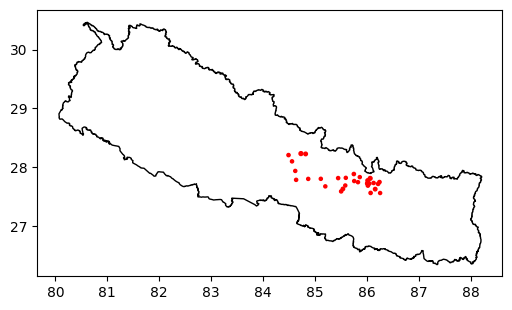

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
nepal.plot(color="white", edgecolor="black", ax=ax)
quakes.plot(ax=ax, markersize='mag', color="red")
plt.show()

Of course, some of these earthquakes might not be foreshocks or aftershocks, but that shouldn't matter for the purpose of this post. The main goal is to animate the scatter plot.

## Generating the animated plot

My goals for the plot were to:

1. animate the time the earthquake occurred,
2. marker sizes indicating the earthquake's magnitude,
3. add a legend for the magnitude.

### Marker size for magnitudes

Earthquake magnitudes are logarithmic in nature; for example, a magnitude 7 earthquake is 10 times stronger than a magnitude 6 one. To visualise this, I have used the following formula to calculate the marker size for the earthquakes.

$marker\_size = base\_size \times 10^{(magnitude - base\_magnitude)}$

In [4]:
min_marker_size = 10
min_magnitude = 5
quakes["marker_size"] = min_marker_size * (10 ** (quakes["mag"] - min_magnitude))

quakes.head()

,mag,time,geometry,longitude,latitude,marker_size
0,7.8,2015-04-25 06:11:25.950000+05:45,POINT Z (84.7314 28.2305 8.22),84.7314,28.2305,6309.573445
1,6.1,2015-04-25 06:15:22.910000+05:45,POINT Z (85.5398 27.6285 10),85.5398,27.6285,125.892541
2,5.6,2015-04-25 06:18:10.870000+05:45,POINT Z (86.0213 27.6857 10),86.0213,27.6857,39.810717
3,5.4,2015-04-25 06:20:40.340000+05:45,POINT Z (84.492 28.2046 10),84.4920,28.2046,25.118864
4,5.1,2015-04-25 06:22:02.750000+05:45,POINT Z (85.1141 27.8006 10),85.1141,27.8006,12.589254


### A basic animated scatter plot

Generating a simple animated scatter plot in *Matplotlib* is quite easy. Let's do that to start with.

In [6]:
import contextily as cx
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(layout="constrained", figsize=(6,5))
ax.set(xlim=[minlongitude, maxlongitude], ylim=[minlatitude, maxlatitude])
ax.set_title("The April 2015 Nepal earthquake and its aftershocks")

# add basemap
cx.add_basemap(ax, crs=quakes.crs, zoom=8, source="CartoDB.Voyager")

# the first point in the animation
points_opts = dict(alpha=0.5, linewidth=0, color="red")
points = ax.scatter(
    quakes["longitude"].iloc[0],
    quakes["latitude"].iloc[0],
    s=quakes["marker_size"].iloc[0],
    **points_opts
)

# the first label
# labels show the time of the earthquake
label_opts = dict(ha="center", va="center", fontsize=15, color="black", transform=ax.transAxes)
label = ax.text(
    0.25,
    0.95,
    quakes["time"].iloc[0].strftime("%Y-%m-%d %H:%M"),
    **label_opts
)

# loop through each point in the data and draw a marker and legend for that data point
def update(frame):
    # for each frame, update the data stored on each artist.
    x = quakes["longitude"].iloc[:frame]
    y = quakes["latitude"].iloc[:frame]

    # update the scatter plot:
    data = np.stack([x, y]).T
    points.set_offsets(data)

    # set the size of the earthquakes
    points.set_sizes(quakes["marker_size"].iloc[:frame])

    # update the label
    label.set_text(quakes["time"].iloc[frame - 1].strftime("%Y-%m-%d %H:%M"))

    return (points,)


# animate by looping through all datapoints.
ani = animation.FuncAnimation(
    fig=fig, func=update, frames=len(quakes), interval=600
)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=10, bitrate=1800)
ani.save("animated-scatter-v1.gif", writer=writer)


plt.ioff
plt.close()

This gives us a nice animated scatter plot.\
![Animated plot](./animated-scatter-v1.gif)

But the legend is missing, without which the marker sizes don't have much meaning. I found adding the correct legend to be the most difficult part of this process because there aren't many working examples of this on the WWW.

### Custom legend
The solution that I ended up using is to add a custom legend that doesn't completely correspond with the data being plotted. This is because I wanted to show the magnitude legend from the get go even when only a small part of the data has been plotted initially. I used the [example](https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html) in the official documentation as a starting point.

I want the legend to have 4 different sizes: 5, 6, 7, and 7.8 (*the strongest earthquake*). My first attempt was to generate the marker sizes as I did above and generate the legend. I added a Line2D object for each marker size, and use the collection of those Line2D objects to create the legend.

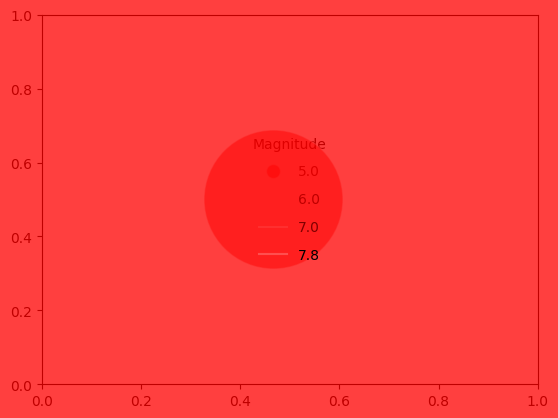

In [7]:
from matplotlib.lines import Line2D

# the four magnitudes in the legend
mags = np.array([5, 6, 7, quakes['mag'].max()])
marker_sizes = min_marker_size * (10 ** (mags - min_magnitude))

def get_legend_elements(marker_sizes):
    # marker size for each magnitude
    marker_opts = dict(marker="o", color="w", markerfacecolor="red", alpha=0.5)
    legend_elements = [
        Line2D(
            [0],
            [i],
            label=mags[i],
            markersize=s,
            **marker_opts
        )
        for i, s in enumerate(marker_sizes)
    ]
    return legend_elements

fig, ax = plt.subplots()
legend_opts = dict(title="Magnitude", labelspacing=1, frameon=False)
ax.legend(handles=get_legend_elements(marker_sizes), **legend_opts, loc='center')

That did't work as exepcted as the marker sizes were too big and didn't align with the marker sizes on the scatter plot. I arrived at the solution after a lot of digging around and trial and error.

Looking at the `scatterplot` [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html), it turns out that the marker size (`s`) is _points \*\* 2_. However, the marker size (`markersize`) in Line2D is only in _points_ This means the marker size for the legend should be square roots of the marker size for the scatter plot. *Perhaps I should have realised this much sooner.*

Below is the 2nd version of the legend; and the sizes correspond with those in the plot.

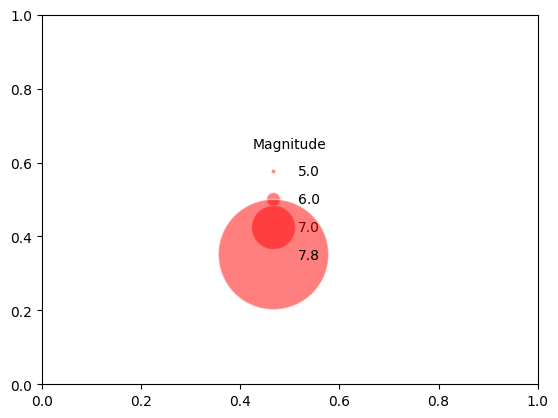

In [8]:
# marker size for each magnitude
marker_sizes = np.sqrt(min_marker_size * (10 ** (mags - min_magnitude)))

fig, ax = plt.subplots()
ax.legend(
    handles=get_legend_elements(marker_sizes),
    loc="center",
    title="Magnitude",
    labelspacing=1,
    frameon=False
)
plt.show()

## Second attempt

In [9]:
fig, ax = plt.subplots(layout="constrained", figsize=(7,5))
ax.set(xlim=[minlongitude, maxlongitude], ylim=[minlatitude, maxlatitude])
ax.set_title("The April 2015 Nepal earthquake and its aftershocks")
cx.add_basemap(ax, crs=quakes.crs, zoom=8, source="CartoDB.Voyager")

points = ax.scatter(
    quakes["longitude"].iloc[0],
    quakes["latitude"].iloc[0],
    s=quakes["marker_size"].iloc[0],
    **points_opts
)

label = ax.text(
    0.25,
    0.95,
    quakes["time"].iloc[0].strftime("%Y-%m-%d %H:%M"),
    **label_opts
)

ax.legend(
    handles=get_legend_elements(marker_sizes),
    loc="center left",
    title="Magnitude",
    labelspacing=1,
    frameon=False,
    bbox_to_anchor=(1.05, 0.5), # place the legend to the right
)

ani = animation.FuncAnimation(
    fig=fig, func=update, frames=len(quakes), interval=600
)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=15, bitrate=1800)
ani.save("animated-scatter-v2.gif", writer=writer)

plt.ioff
plt.close()

Finally, this gave me the animated plot that I wanted to create.\
![Animated scatter plot v2](./animated-scatter-v2.gif).